In [9]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd /content/gdrive/MyDrive/Colab Notebooks/21 - Pytorch/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Colab Notebooks/21 - Pytorch


In [10]:
import torch
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [11]:
vgg = models.vgg19(pretrained=True).features

# to make parameteres constant
for param in vgg.parameters():
    param.requires_grad_(False)

In [12]:
def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert('RGB')
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
 
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), 
                                             (0.5, 0.5, 0.5))])
    image = in_transform(image).unsqueeze(0)
    return image

In [13]:
content = load_image('./data/images/City.jpg')
style = load_image('./data/images/StarryNight.jpg')

In [14]:
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

(-0.5, 615.5, 399.5, -0.5)

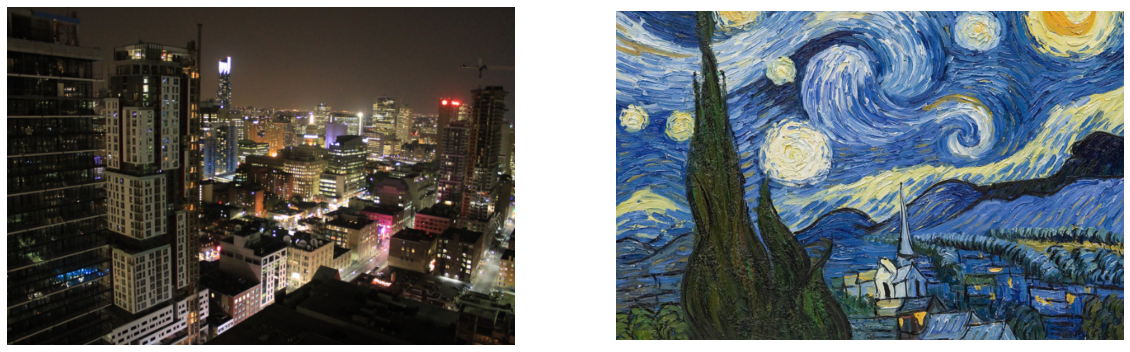

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis("off")
ax2.imshow(im_convert(style))
ax2.axis("off")

In [16]:
def get_features(image, model):
    layers = {'0': 'conv1_1',
              '5': 'conv2_1', 
              '10': 'conv3_1', 
              '19': 'conv4_1',
              '21': 'conv4_2',  # Content Extraction
              '28': 'conv5_1'}
        
    features = {}

    for name, layer in model._modules.items():
        image = layer(image)
        if name in layers:
            features[layers[name]] = image
            
    return features

In [17]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [18]:
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

In [19]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

In [20]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

In [21]:
target = content.clone().requires_grad_(True)

In [22]:
show_every = 300
optimizer = optim.Adam([target], lr=0.003)
steps = 2100

height, width, channels = im_convert(target).shape
image_array = np.empty(shape=(300, height, width, channels))
capture_frame = steps/300
counter = 0

In [ ]:
for ii in range(1, steps+1):
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    style_loss = 0
  
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        _, d, h, w = target_feature.shape
        style_loss += layer_style_loss / (d * h * w)
  
    total_loss = content_weight * content_loss + style_weight * style_loss
  
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
  
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        print('Iteration: ', ii)
        plt.imshow(im_convert(target))
        plt.axis("off")
        plt.show()
    
    if ii % capture_frame == 0:
        image_array[counter] = im_convert(target)
        counter = counter + 1

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')
ax3.imshow(im_convert(target))
ax3.axis('off')

In [ ]:
import cv2 

frame_height, frame_width, _ = im_convert(target).shape
vid = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'XVID'), 30, (frame_width, frame_height))

for i in range(0, 300):
    img = image_array[i]
    img = img*255
    img = np.array(img, dtype = np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    vid.write(img)

vid.release()